In [ ]:
import csv
import codecs
import argparse
import os
from pathlib import Path
import pandas as pd
import sys, argparse
from sklearn import metrics
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import gc
from spacy.lang.en import English
from nltk.stem.porter import *
import re
import string
from tqdm import tqdm
import numpy as np
from scipy.sparse import coo_matrix, vstack
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter
from bs4 import BeautifulSoup

In [ ]:
path = '/content/drive/MyDrive/DATA641 Final Project/nlp_project_data/umd_reddit_suicidewatch_dataset_v2/'

# **Functions**

In [ ]:
def normalize_tokens(tokenlist):
    normalized_tokens = [token.lower().replace('_','+') for token in tokenlist   # lowercase, _ => +
                             if re.search('[^\s]', token) is not None            # ignore whitespace tokens
                             and not token.startswith("@")                       # ignore  handles
                        ]
    return normalized_tokens    

def ngrams(tokens, n):
    return [tokens[i:i+n] for i in range(len(tokens)-n+1)]

def filter_punctuation_bigrams(ngrams):
    punct = string.punctuation
    return [ngram   for ngram in ngrams   if ngram[0] not in punct and ngram[1] not in punct]

def filter_stopword_bigrams(ngrams, stopwords):
    result = [ngram   for ngram in ngrams   if ngram[0] not in stopwords and ngram[1] not in stopwords]
    return result

In [ ]:
def convert_text_into_features(X, stopwords_arg, analyzefn="word", range=(1,1)):
    training_vectorizer = CountVectorizer(stop_words=stopwords_arg,
                                          analyzer=analyzefn,
                                          lowercase=True,
                                          ngram_range=range)
    X_features = training_vectorizer.fit_transform(X)
    return X_features, training_vectorizer

def convert_lines_to_feature_strings(lines, stopwords, remove_stopword_bigrams=True):

    print(" Converting from raw text to unigram and bigram features")
    if remove_stopword_bigrams:
        print(" Includes filtering stopword bigrams")
        
    print(" Initializing")
    stemmer = PorterStemmer()
    nlp          = English(parser=False)
    all_features = []
    print(" Iterating through documents extracting unigram and bigram features")
    for line in tqdm(lines):
        
        # Get spacy tokenization and normalize the tokens
        spacy_analysis    = nlp(line)
        spacy_tokens      = [token.orth_ for token in spacy_analysis]
        spacy_tokens      = [stemmer.stem(token) for token in spacy_tokens]
        normalized_tokens = normalize_tokens(spacy_tokens)

        # Collect unigram tokens as features
        # Exclude unigrams that are stopwords or are punctuation strings (e.g. '.' or ',')
        unigrams          = [token   for token in normalized_tokens
                                 if token not in stopwords and token not in string.punctuation]

        # Conjoin the feature lists and turn into a space-separated string of features.
        # E.g. if unigrams is ['coffee', 'cup'] and bigrams is ['coffee_cup', 'white_house']
        # then feature_string should be 'coffee cup coffee_cup white_house'

        unigrams = " ".join(unigrams)
        feature_string = unigrams 

        # Add this feature string to the output
        all_features.append(feature_string)


    print(" Feature string for first document: '{}'".format(all_features[0]))
        
    return all_features

def most_informative_features(vectorizer, classifier, n=20):
    # Adapted from https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers#11116960
    feature_names       = vectorizer.get_feature_names()
    coefs_with_features = sorted(zip(classifier.coef_[0], feature_names))
    top                 = zip(coefs_with_features[:n], coefs_with_features[:-(n + 1):-1])
    for (coef_1, feature_1), (coef_2, feature_2) in top:
        print("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, feature_1, coef_2, feature_2))

In [ ]:
def load_stopwords(filename):
    stopwords = []
    with codecs.open(filename, 'r', encoding='ascii', errors='ignore') as fp:
        stopwords = fp.read().split('\n')
    return set(stopwords)

stopwords = load_stopwords(path+'mallet_en_stoplist.txt')   

In [ ]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]/,.!?]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

# **Loading Data**

In [ ]:
crowd_train = pd.read_csv(path+'crowd/train/crowd_train.csv')
task_A_train = pd.read_csv(path+'crowd/train/task_A_train.posts.csv')
task_B_train = pd.read_csv(path+'crowd/train/task_B_train.posts.csv')
task_C_train = pd.read_csv(path+'crowd/train/task_B_train.posts.csv')
shared_task_train = pd.read_csv(path+'crowd/train/shared_task_posts.csv')

In [ ]:
crowd_test = pd.read_csv(path+'crowd/test/crowd_test.csv')
task_A_test = pd.read_csv(path+'crowd/test/task_A_test.posts.csv')
task_B_test = pd.read_csv(path+'crowd/test/task_B_test.posts.csv')
task_C_test = pd.read_csv(path+'crowd/test/task_B_test.posts.csv')
shared_task_test = pd.read_csv(path+'crowd/test/shared_task_posts_test.csv')

In [ ]:
label = np.array(['a','b','c','d'])
c = np.array(['Negative','Negative','Negative','Positive'])

d = np.vstack([label,c])

df_class = pd.DataFrame(data=d.T,columns=['label','class'])

df_class

,label,class
0,a,Negative
1,b,Negative
2,c,Negative
3,d,Positive


# **Task - only Suicide Watch**

In [ ]:
df_A_train = shared_task_train[shared_task_train['subreddit'] == 'SuicideWatch']
df_A_train = df_A_train.dropna()

In [ ]:
df_A_train = pd.merge(df_A_train,crowd_train,on='user_id')

df_A_train = pd.merge(df_A_train,df_class,on='label')

In [ ]:
df_A_test = shared_task_test[shared_task_test['subreddit'] == 'SuicideWatch']
df_A_test = df_A_test.dropna()

df_A_test = pd.merge(df_A_test,crowd_test,on='user_id')

df_A_test['label'] = df_A_test['raw_label']

df_A_test = pd.merge(df_A_test,df_class,on='label')

In [ ]:
X_train = convert_lines_to_feature_strings(df_A_train['post_body'],stopwords)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing


  0%|          | 3/847 [00:00<00:37, 22.37it/s]

 Iterating through documents extracting unigram and bigram features


100%|██████████| 847/847 [00:47<00:00, 17.96it/s]

 Feature string for first document: 'wa parti everyon fun ... smoke ... n't rememb fuck hurt 's 's noth compar pain insid thing ... peopl n't sad beacus talk problem ... fine okey .. peopl cool person confid ... fuck wrong scar someth real ... glad ... open hand ... 's head ... wit depress ... thing real ... thi scar 21 male ... feel 80 ... share thought ..'


In [ ]:
X_train, training_vectorizer = convert_text_into_features(X_train,stopwords)

In [ ]:
X_test = convert_lines_to_feature_strings(df_A_test['post_body'],stopwords)
X_test = training_vectorizer.transform(X_test)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing


  1%|          | 2/181 [00:00<00:12, 14.61it/s]

 Iterating through documents extracting unigram and bigram features


100%|██████████| 181/181 [00:09<00:00, 18.60it/s]

 Feature string for first document: 'realli n't hand 've told stay aliv persever life hand blow brain end matter happen die accept happen'


In [ ]:
data_A = pd.concat([df_A_train,df_A_test],axis=0)

In [ ]:
x = convert_lines_to_feature_strings(data_A['post_body'],stopwords)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing


  0%|          | 2/1028 [00:00<01:09, 14.84it/s]

 Iterating through documents extracting unigram and bigram features


100%|██████████| 1028/1028 [00:53<00:00, 19.27it/s]

 Feature string for first document: 'wa parti everyon fun ... smoke ... n't rememb fuck hurt 's 's noth compar pain insid thing ... peopl n't sad beacus talk problem ... fine okey .. peopl cool person confid ... fuck wrong scar someth real ... glad ... open hand ... 's head ... wit depress ... thing real ... thi scar 21 male ... feel 80 ... share thought ..'


### **Logistic Regression**

In [ ]:
lr_classifier = LogisticRegression(solver='liblinear')
lr_classifier.fit(X_train, df_A_train['class'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
most_informative_features(training_vectorizer,lr_classifier,20)

	-1.5341	url            		0.9172	knife          
	-0.9987	hour           		0.8488	part           
	-0.8678	advic          		0.8482	forgiv         
	-0.8234	promis         		0.8382	mess           
	-0.8113	bad            		0.8044	throat         
	-0.8030	contempl       		0.8031	aliv           
	-0.7462	12             		0.7851	world          
	-0.7427	sad            		0.7776	upset          
	-0.7376	matter         		0.7371	enjoy          
	-0.7257	idea           		0.6974	pain           
	-0.7206	situat         		0.6762	pill           
	-0.7047	male           		0.6679	lone           
	-0.6905	throwaway      		0.6500	weak           
	-0.6729	strong         		0.6375	gon            
	-0.6690	solut          		0.6146	ruin           
	-0.6511	subreddit      		0.6073	piec           
	-0.6437	comit          		0.6057	failur         
	-0.6407	earli          		0.6026	lot            
	-0.6344	play           		0.5994	hear           
	-0.6278	phone          		0.5943	plan           


In [ ]:
lr_classifier.score(X_test,df_A_test['class'])

0.5524861878453039

In [ ]:
X_features,_ = convert_text_into_features(x,stopwords)

In [ ]:
accuracy_scores = cross_val_score(lr_classifier, X_features, 
                                  data_A['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

accuracy scores = [0.6180758  0.56559767 0.56725146], mean = 0.5836416437920198, stdev = 0.024357985475083645


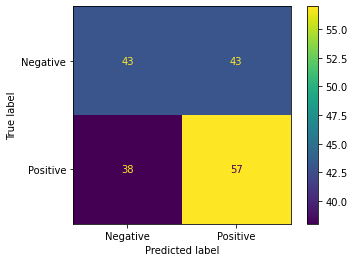

In [ ]:
metrics.plot_confusion_matrix(lr_classifier,X_test,df_A_test['class'])

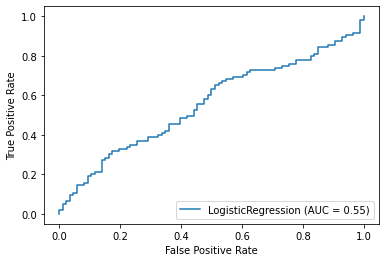

In [ ]:
metrics.plot_roc_curve(lr_classifier, X_test, df_A_test['class'])

### **Decision Trees**

In [ ]:
tree = DecisionTreeClassifier(criterion='entropy')
tree.fit(X_train,df_A_train['class'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tree.score(X_test,df_A_test['class'])

0.5082872928176796

In [ ]:
accuracy_scores = cross_val_score(tree, X_features, 
                                  data_A['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores, np.mean(accuracy_scores), np.std(accuracy_scores)))

accuracy scores = [0.60641399 0.51020408 0.5497076 ], mean = 0.5554418927136435, stdev = 0.03948627088108388


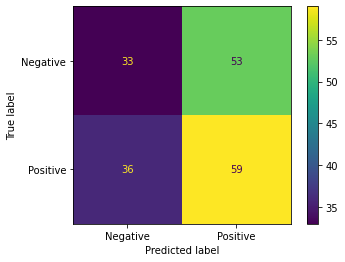

In [ ]:
metrics.plot_confusion_matrix(tree,X_test,df_A_test['class'])

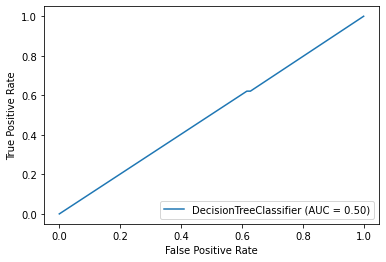

In [ ]:
metrics.plot_roc_curve(tree, X_test, df_A_test['class'])

# **Task - everything**

In [ ]:
df_B_train = shared_task_train
df_B_train = df_B_train.dropna()
df_B_train = pd.merge(df_B_train,crowd_train,on='user_id')
df_B_train = pd.merge(df_B_train,df_class, on = 'label')

In [ ]:
df_B_test = shared_task_test
df_B_test = df_B_test.dropna()
df_B_test = pd.merge(df_B_test,crowd_test,on='user_id')
df_B_test['label'] = df_B_test['raw_label']
df_B_test = pd.merge(df_B_test,df_class, on = 'label')

In [ ]:
x_b = convert_lines_to_feature_strings(df_B_train['post_body'],stopwords)

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing


  0%|          | 2/16600 [00:00<17:11, 16.09it/s]

 Iterating through documents extracting unigram and bigram features


100%|██████████| 16600/16600 [13:32<00:00, 20.43it/s]

 Feature string for first document: 'thi post reddit time ago chang life fit seduc beati women pass exam wa onli word real motiv dosen't movi watch book read everyth 3 year realiz thi wa site famou peopl monument real motiv perspect life liter chang aspect life motiv fuck soul conscious person thi work place dont person fit dont person person girl moment life realiz hammer face soul cri beacus person explod nuklear bomb motiv person person reflect liter everyth possibl creat road succ whatev exampl wa time ... wa fat soo fat nt „ ” run run ... mater matter long wa someth 6 month run 5 minut day ago make test ... wa abl run 20 minut ... 30 minut ... 40 minut broke chain run 60 minut time life wa tire hell peopl wa person anymor wa creat tear sweat wa feel god wa messiah guy thi websit love thi awesom place day write someth'


In [ ]:
X_train_b, training_vectorizer_b = convert_text_into_features(x_b,stopwords)

In [ ]:
X_test_b =  convert_lines_to_feature_strings(df_B_test['post_body'],stopwords)
X_test_b_features = training_vectorizer_b.transform(X_test_b)

  0%|          | 0/4906 [00:00<?, ?it/s]

 Converting from raw text to unigram and bigram features
 Includes filtering stopword bigrams
 Initializing
 Iterating through documents extracting unigram and bigram features


100%|██████████| 4906/4906 [04:00<00:00, 20.38it/s]


 Feature string for first document: 'realli n't hand 've told stay aliv persever life hand blow brain end matter happen die accept happen'


### **Logistic Regression**

In [ ]:
lr_classifier_b = LogisticRegression(solver='liblinear')
lr_classifier_b.fit(X_train_b, df_B_train['class'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
most_informative_features(training_vectorizer_b,lr_classifier_b,20)

	-1.6023	salust         		2.2865	thealderbunni  
	-1.5369	lcr999         		2.2256	deet           
	-1.5258	twin           		1.6163	endur          
	-1.5130	askmen         		1.6002	expir          
	-1.4996	eleven         		1.5359	israel         
	-1.4681	secondari      		1.5316	geek           
	-1.4078	hotel          		1.5086	amiibo         
	-1.3983	atom           		1.5041	loneli         
	-1.3706	beacus         		1.4858	rotc           
	-1.3588	intrigu        		1.4341	nazi           
	-1.3503	torrent        		1.4199	wich           
	-1.3487	inch           		1.3696	autism         
	-1.3126	btw            		1.3694	roam           
	-1.3110	heaven         		1.3405	disney         
	-1.3097	disagre        		1.3380	dbt            
	-1.3042	soccerstud2691 		1.3280	dimens         
	-1.2780	grant          		1.3275	bday           
	-1.2678	vulner         		1.3251	breadstick     
	-1.2568	pl             		1.3184	mashup         
	-1.2563	gal            		1.3160	psn            


In [ ]:
lr_classifier_b.score(X_test_b_features,df_B_test['class'])

0.5185487158581329

In [ ]:
x_features_b = vstack([X_train_b,X_test_b_features])
data_B = pd.concat([df_B_train,df_B_test],axis=0)

In [ ]:
accuracy_scores_b = cross_val_score(lr_classifier_b, x_features_b, data_B['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores_b, 
                                                           np.mean(accuracy_scores_b), 
                                                           np.std(accuracy_scores_b)))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


accuracy scores = [0.53563956 0.52545683 0.53083147], mean = 0.5306426201456834, stdev = 0.004159226915611555


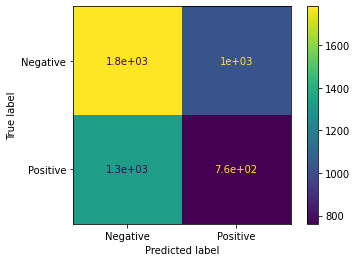

In [ ]:
metrics.plot_confusion_matrix(lr_classifier_b,X_test_b_features,df_B_test['class'])

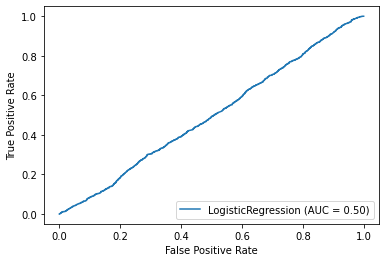

In [ ]:
metrics.plot_roc_curve(lr_classifier_b, X_test_b_features,df_B_test['class'])

### **Decision Trees**

In [ ]:
tree_b = DecisionTreeClassifier(criterion='entropy')
tree_b.fit(X_train_b, df_B_train['class'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
tree_b.score(X_test_b_features,df_B_test['class'])

0.5362821035466775

In [ ]:
accuracy_scores = cross_val_score(tree_b, x_features_b, data_B['class'],cv= 3)
print("accuracy scores = {}, mean = {}, stdev = {}".format(accuracy_scores_b, 
                                                           np.mean(accuracy_scores_b), 
                                                           np.std(accuracy_scores_b)))

accuracy scores = [0.53563956 0.52545683 0.53083147], mean = 0.5306426201456834, stdev = 0.004159226915611555


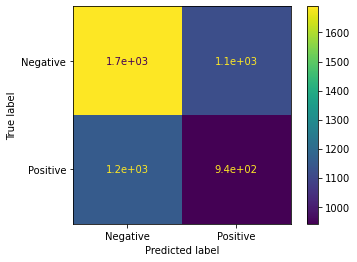

In [ ]:
metrics.plot_confusion_matrix(tree_b,X_test_b_features,df_B_test['class'])

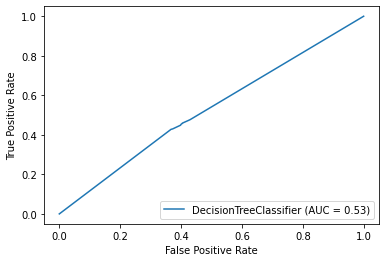

In [ ]:
metrics.plot_roc_curve(tree_b, X_test_b_features,df_B_test['class'])